<a href="https://colab.research.google.com/github/rikunemu/colab_study/blob/main/pose_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  mediapipeで取ったposeの特徴点を分析

90分対策  
F12を開いて以下のスクリプトをコンソールで実行  
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,600000)

  
10分ごとに接続

参考url:
https://sunnyday-travel-aso-6487.ssl-lolipop.jp/programing/python/keras/lstm-use/

In [1]:
import sys
from google.colab import drive
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import csv
import os
import keras
from keras import models
from keras.models import Sequential, load_model
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
drive.mount("/content/drive")

Mounted at /content/drive


## csvデータ読み込み
train,test,validそれぞれ7感情の特徴点を記録

In [2]:
fp_train='/content/drive/MyDrive/data分析/join_csv/csvtrainresult.csv'
df_train=pd.read_csv(fp_train)
fp_test='/content/drive/MyDrive/data分析/join_csv/csvtestresult.csv'
df_test=pd.read_csv(fp_test)

Unnameはいらないので削除

In [3]:
df_test=df_test.replace('NAN',0.1)
df_train=df_train.replace('NAN',0.1)

In [4]:
df_train=df_train.drop(columns=df_train.columns[[0]],axis=1)

In [5]:
df_test=df_test.drop(columns=df_test.columns[[0]],axis=1)

In [6]:
df_train=df_train.fillna(0.1)
df_test=df_test.fillna(0.1)

それぞれのデータを目的変数と説明変数に分ける

In [7]:
x_train=DataFrame(df_train.drop("correct",axis=1)).values
Y_train=DataFrame(df_train["correct"]-1).values
x_test=DataFrame(df_test.drop("correct",axis=1)).values
Y_test=DataFrame(df_test["correct"]-1).values

X_test = np.array(x_test).reshape(200, 30,162)
Y_test = np.array(Y_test[::30]).reshape(200)
y_test = np_utils.to_categorical(Y_test,20)
y_test = y_test.astype(np.float)
X_test = X_test.astype(np.float)

In [8]:
def build_model(maxlen):
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,maxlen)))
  model.add(Dropout(0.1))
  model.add(LSTM(128, return_sequences=True, activation='relu'))
  model.add(Dropout(0.1))
  model.add(LSTM(64, return_sequences=False, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(20, activation='softmax'))
  adam = Adam(learning_rate=1e-4)
  model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [9]:
def plot_history(history):
    # print(history.history.keys())

    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()
    plt.close()

In [10]:
def cmd_pose(Y_test,y_pred):
  cm = confusion_matrix(Y_test, y_pred)
  #表示
  cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  fig, ax = plt.subplots(figsize=(10, 10))
  cmd.plot(ax=ax, cmap="Blues")
  plt.show()
  plt.close()
  return

Epoch 1/300
45/45 [==============================] - ETA: 0s - loss: 2.9930 - accuracy: 0.0556
Epoch 00001: val_accuracy improved from -inf to 0.05000, saving model to /content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5
45/45 [==============================] - 10s 128ms/step - loss: 2.9930 - accuracy: 0.0556 - val_loss: 2.9830 - val_accuracy: 0.0500
Epoch 2/300
45/45 [==============================] - ETA: 0s - loss: 2.9679 - accuracy: 0.0569
Epoch 00002: val_accuracy improved from 0.05000 to 0.08750, saving model to /content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5
45/45 [==============================] - 5s 101ms/step - loss: 2.9679 - accuracy: 0.0569 - val_loss: 2.9023 - val_accuracy: 0.0875
Epoch 3/300
45/45 [==============================] - ETA: 0s - loss: 2.8728 - accuracy: 0.0708
Epoch 00003: val_accuracy did not improve from 0.08750
45/45 [==============================] - 5s 100ms/step - loss: 2.8728 - accuracy: 0.0708 - val_loss: 2.7584 - val_accuracy: 0.0750
Epoch 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


              precision    recall  f1-score   support

           1       0.50      0.20      0.29        10
           2       0.70      0.70      0.70        10
           3       0.67      0.60      0.63        10
           4       1.00      1.00      1.00        10
           5       0.58      0.70      0.64        10
           6       0.82      0.90      0.86        10
           7       0.75      0.60      0.67        10
           8       0.75      0.30      0.43        10
           9       0.67      0.80      0.73        10
          10       0.88      0.70      0.78        10
          11       0.75      0.90      0.82        10
          12       0.45      0.50      0.48        10
          13       0.53      0.90      0.67        10
          14       0.38      0.30      0.33        10
          15       1.00      0.80      0.89        10
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        10
          18       0.59    

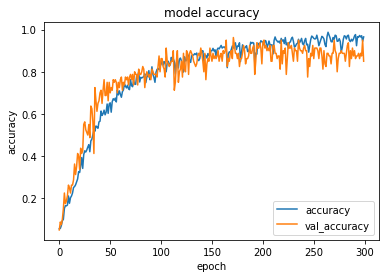

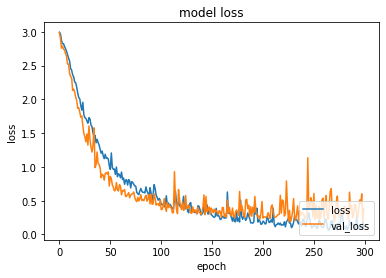

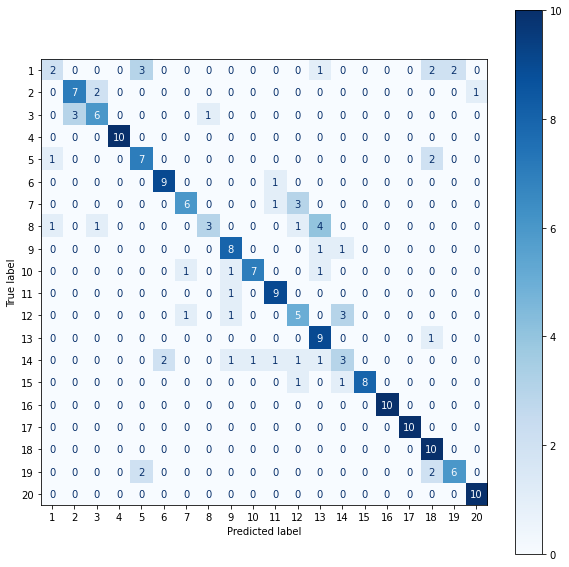

Epoch 1/300
45/45 [==============================] - ETA: 0s - loss: 2.9922 - accuracy: 0.0681
Epoch 00001: val_accuracy improved from -inf to 0.11250, saving model to /content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5
45/45 [==============================] - 10s 122ms/step - loss: 2.9922 - accuracy: 0.0681 - val_loss: 2.9832 - val_accuracy: 0.1125
Epoch 2/300
45/45 [==============================] - ETA: 0s - loss: 2.9584 - accuracy: 0.0861
Epoch 00002: val_accuracy did not improve from 0.11250
45/45 [==============================] - 5s 103ms/step - loss: 2.9584 - accuracy: 0.0861 - val_loss: 2.8691 - val_accuracy: 0.1125
Epoch 3/300
45/45 [==============================] - ETA: 0s - loss: 2.8728 - accuracy: 0.1208
Epoch 00003: val_accuracy improved from 0.11250 to 0.12500, saving model to /content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5
45/45 [==============================] - 5s 111ms/step - loss: 2.8728 - accuracy: 0.1208 - val_loss: 2.7839 - val_accuracy: 0.1250
Epoch 4

KeyboardInterrupt: ignored

In [11]:
FOLD = 10
EPOCH = 300
BATCH_SIZE = 16

valid_scores = []
models = []
kf = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=42)

for fold, (train_indices, valid_indices) in enumerate(kf.split(x_train, Y_train)):
    X_train, X_valid = x_train[train_indices], x_train[valid_indices]
    y_train, y_valid = Y_train[train_indices], Y_train[valid_indices]
    

    X_train = np.array(X_train).reshape(720, 30, 162)
    X_valid = np.array(X_valid).reshape(80, 30,162)
    y_train = np.array(y_train[::30]).reshape(720)
    y_valid = np.array(y_valid[::30]).reshape(80)
    y_train = np_utils.to_categorical(y_train,20)
    y_valid = np_utils.to_categorical(y_valid,20)

    X_train = X_train.astype(np.float)
    X_valid = X_valid.astype(np.float)
    y_train = y_train.astype(np.float)
    y_valid = y_valid.astype(np.float)
    model = build_model(X_train.shape[2])

    modelCheckpoint = ModelCheckpoint(filepath ='/content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5',
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='max',
                                  period=1)

    history=model.fit(X_train, y_train,
              validation_data=(X_valid, y_valid),
              epochs=EPOCH,
              batch_size=BATCH_SIZE,
              callbacks=[modelCheckpoint],
              verbose=1)
    
    model2=load_model('/content/drive/MyDrive/data分析/join_cav/lstm_cross.hdf5')
    score = model2.evaluate(X_test,y_test,verbose=0)
    print(f'fold {fold} score: {score}')
    valid_scores.append(score[1])
    Y_pred = model2.predict_generator(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9","10","11","12","13","14","15","16","17", "18", "19", "20"]
    
    report = metrics.classification_report(Y_test,y_pred, 
                                       labels=np.arange(len(labels)),
                                       target_names=labels)
    print(report)
    # 学習履歴をプロット
    plot_history(history)
    cmd_pose(Y_test,y_pred)
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')
